## Imports

In [34]:
# Generales
import torch
import os
import sys
import pandapower as pp
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from omegaconf import OmegaConf
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

# Julia
import julia
julia.install()
from julia.api import Julia
jl = Julia(compiled_modules=False)


# Internos
sys.path.append(os.path.abspath('../entrenamiento'))
from src.arquitecturas import GNNUnsupervised, FCNNUnsupervised
from src.Data_loader import load_net, load_data
from src.utils import get_Ybus, get_Yline, init_lamdas
from src.Loss import  get_max_min_values



[ Info: Julia version info


Julia Version 1.8.1
Commit afb6c60d69a (2022-09-06 15:09 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
      Ubuntu 22.04.5 LTS
  uname: Linux 6.8.0-45-generic #45~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Sep 11 15:25:05 UTC 2 x86_64 x86_64
  CPU: 13th Gen Intel(R) Core(TM) i5-13400F: 
                 speed         user         nice          sys         idle          irq
       #1-16  4600 MHz     179280 s         59 s      18547 s   97402116 s          0 s
  Memory: 62.63290023803711 GB (44669.921875 MB free)
  Uptime: 610059.45 sec
  Load Avg:  1.35  0.88  0.65
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, goldmont)
  Threads: 1 on 16 virtual cores
Environment:
  HOME = /home/nacho
  PATH = /home/nacho/miniconda3/envs/proy/bin:/home/nacho/.vscode-server/cli/servers/Stable-384ff7382de624fb94dbaf6da11977bba1ecd427/server/bin/remote-cli:/home/nacho/.local/bin:/home/nacho/miniconda3/envs/proy/bin:/home/nacho/miniconda3/condabin:/usr/local/sbin:/usr/local/bin:/us

[ Info: Julia executable: /home/nacho/julia-1.8.1/bin/julia
[ Info: Trying to import PyCall...
┌ Warning: PyCall is already installed.  However, you may have trouble using
│ this Python executable because it is statically linked to libpython.
│ 
│ For more information, see:
│     https://pyjulia.readthedocs.io/en/latest/troubleshooting.html
│ 
│ Python executable:
│     /home/nacho/miniconda3/envs/proy/bin/python
│ Julia executable:
│     /home/nacho/julia-1.8.1/bin/julia
└ @ Main ~/miniconda3/envs/proy/lib/python3.12/site-packages/julia/install.jl:90


## Levantar Red electrica, Predictor y Datos

In [43]:
red = "uru"
arq = "gnn" # "gnn" o "fcnn"
runs_folder = "./runs_ploss_sintetica/" # "./runs_ploss_sintetica/" o "./runs_ploss/"
base_path = runs_folder + arq  + "/best"

# Levantar CFG
cfg = OmegaConf.load(base_path + "/config.yaml")
weights_dir = base_path +  "/weights/best_model.pt"

# Settear GPU
torch.manual_seed(cfg.training.seed)
device = cfg.training.device

# Levantar red electrica
edge_index, edge_weights, net = load_net(cfg.data.red,cfg.data.red_path,device)
net.bus["pm_param/setpoint_v"] = 1.0
pp.runpp(net)
Y_bus = get_Ybus(net,device)
Y_line = get_Yline(net,device)
max_ika = torch.Tensor(net.line["max_i_ka"]).to(device)
dual_variables = init_lamdas(net,cfg.training.dual_coefs,device)
min_vector, max_vector = get_max_min_values(net,device)
num_layers = len(cfg.model.layers) - 1
num_nodes = len(net.bus)

# Levantar modelo
if cfg.model.arq == "GNN":
    model = GNNUnsupervised(cfg.model.layers, edge_index, Y_bus, num_layers, cfg.model.K, min_vector, max_vector, num_nodes,cfg.model.dropout,batch_norm=cfg.training.batch_norm).to(device)
elif cfg.model.arq == "FCNN":
    model = FCNNUnsupervised(cfg.model.layers, edge_index, Y_bus, num_layers, cfg.model.K, min_vector, max_vector, num_nodes,cfg.model.dropout,batch_norm=cfg.training.batch_norm).to(device)

# Levantar data
train_loader, val_loader, test_loader, norm_X = load_data(cfg.data.data_path, cfg.training.batch_size, cfg.data.normalize_X, cfg.data.red, device)
train_loader_unorm, val_loader_unorm, test_loader_unorm, _ = load_data(cfg.data.data_path, cfg.training.batch_size, False, cfg.data.red, device)

# Cargo los pesos
model.load_state_dict(torch.load(weights_dir))
model.eval()

GNNUnsupervised(
  (convs): ModuleList(
    (0): TAGConv(4, 512, K=4)
    (1): TAGConv(512, 512, K=4)
    (2): TAGConv(512, 5, K=4)
  )
  (batchnorm): ModuleList(
    (0-1): 2 x BatchNorm(54784)
    (2): BatchNorm(535)
  )
  (dropout): Dropout(p=0.011268544720390909, inplace=False)
  (relu): LeakyReLU(negative_slope=0.01)
)

## Predecir Salidas en Test

In [44]:
# Función auxiliar para obtener la posición de los buses
bus_map = {net.bus.index[i]: i for i in range(len(net.bus))}
def bus_pos(buses):
    try:
        return [bus_map[bus] for bus in buses]
    except:
        return bus_map[buses]

In [45]:
data_path = cfg.data.data_path

y_tensor_test_vmpu = torch.Tensor(np.load(f'{data_path}/test/vm_pu_opt.npy')).to(device)
y_tensor_test_qsh = torch.Tensor(np.load(f'{data_path}/test/q_switch_shunt_opt.npy')).to(device)

data_test_v = TensorDataset( y_tensor_test_vmpu)
test_loader_Y_v = DataLoader(data_test_v, batch_size=cfg.training.batch_size)#,drop_last=True)

data_test_sh = TensorDataset( y_tensor_test_qsh)
test_loader_Y_sh = DataLoader(data_test_sh, batch_size=cfg.training.batch_size)#,drop_last=True)

combined_dataloader = zip(test_loader, test_loader_Y_v,test_loader_Y_sh )


idx_gens = net.gen.bus.values.astype(int)
idx_load = net.load.bus.values.astype(int)
idx_shunts = net.sgen.bus.loc[net.sgen.controllable==True].values.astype(int)
idx_sgen = net.sgen.bus.loc[net.sgen.controllable==False].values.astype(int)

y_pred_vmpu = []
y_pred_sh = []
x_tot = []
y_tot_vmpu = []
y_tot_sh = []
y_pred = []
for input,y_vmpu,y_sh in combined_dataloader:
    output = model(input[0]).detach().cpu().numpy()
    y_pred.append(output)
    y_pred_vmpu.append(output[:,:,3])
    y_pred_sh.append(output[:,:,2])
    y_tot_vmpu.append(y_vmpu[0].detach().cpu().numpy())
    y_tot_sh.append(y_sh[0].detach().cpu().numpy())

for input in test_loader_unorm:
    x_tot.append(input[0].detach().cpu().numpy())


y_pred_vmpu = np.concatenate(y_pred_vmpu, axis=0)
y_pred_vmpu = y_pred_vmpu[:,:,None]
y_pred_sh = np.concatenate(y_pred_sh, axis=0)
y_pred_sh = y_pred_sh[:,:,None]
x_tot = np.concatenate(x_tot, axis=0)
y_tot_vmpu = np.concatenate(y_tot_vmpu, axis=0)
y_tot_vmpu = y_tot_vmpu[:,:,None]
y_tot_sh = np.concatenate(y_tot_sh, axis=0)
y_tot_sh = y_tot_sh[:,:,None]
y_pred = np.concatenate(y_pred, axis=0)
 

## Evaluar desempeño como solucion del ORPD

### Función para evaluar pérdias y unfeasiblity

In [46]:
def get_stats(net,tol=1e-3, percent_gap=None):
    
    # METRICA
    Y_line_ij = np.asarray(net._ppc["internal"]["Yf"].todense())
    Y_line_ji = np.asarray(net._ppc["internal"]["Yt"].todense())
    V_mag = net.res_bus.vm_pu
    delta = net.res_bus.va_degree
    V = V_mag * np.exp(1j * delta * 2*np.pi/360)
    V_lines_to = [V[x] for x in net.line.to_bus] + [V[x] for x in net.trafo.lv_bus]
    V_lines_from = [V[x] for x in net.line.from_bus] + [V[x] for x in net.trafo.hv_bus]
    ploss = (V_lines_from * np.conj(np.matmul(Y_line_ij,V)) + V_lines_to * np.conj(np.matmul(Y_line_ji,V))).real * net.sn_mva
    ploss_cost = ploss.sum()
    
    # UNFEASIBILITY
    
    ## Lineas
    
    max_line = net.line.max_loading_percent.values.copy()
    if percent_gap is not None:
        max_line = max_line * (1 + percent_gap)
    unfeas_line = (net.res_line.loading_percent.values > max_line + tol).sum()
    gap_line_max = (net.res_line.loading_percent.values - net.line.max_loading_percent.values - tol)/(net.line.max_loading_percent.values - 0)
    gap_line_max = gap_line_max[np.where(gap_line_max > 0)] * 100

    ## Trafos
    unfeas_trafo = 0
    gap_trafo_max = []
    if len(net.trafo) > 0:
        max_trafo = net.trafo.max_loading_percent.values.copy()
        if percent_gap is not None:
            max_trafo = max_trafo * (1 + percent_gap)
        unfeas_trafo = (net.res_trafo.loading_percent.values > max_trafo + tol).sum()
        gap_trafo_max = (net.res_trafo.loading_percent.values - net.trafo.max_loading_percent.values - tol)/(net.trafo.max_loading_percent.values - 0)
        gap_trafo_max = gap_trafo_max[np.where(gap_trafo_max > 0)] * 100
    else:
        unfeas_trafo = 0
    
    ## Voltajes
    max_volt = net.bus.max_vm_pu.values.copy()
    min_volt = net.bus.min_vm_pu.values.copy()
    if percent_gap is not None:
        max_volt +=  percent_gap*(net.bus.max_vm_pu.values - net.bus.min_vm_pu.values)
        min_volt -= percent_gap*(net.bus.max_vm_pu.values - net.bus.min_vm_pu.values)
    unfeas_volt = (net.res_bus.vm_pu.values < min_volt - tol).sum() + (net.res_bus.vm_pu.values > max_volt + tol).sum()
    gap_volt_max = (net.res_bus.vm_pu.values - net.bus.max_vm_pu.values - tol)/(net.bus.max_vm_pu.values - net.bus.min_vm_pu.values)
    gap_volt_max = gap_volt_max[np.where(gap_volt_max > 0)] * 100
    gap_volt_min = (-net.res_bus.vm_pu.values + net.bus.min_vm_pu.values + tol)/(net.bus.max_vm_pu.values - net.bus.min_vm_pu.values)
    gap_volt_min = gap_volt_min[np.where(gap_volt_min > 0)] * 100

    ## Q ext grid    
    max_q_extgrid = net.ext_grid.max_q_mvar.values.astype(float).copy()
    min_q_extgrid = net.ext_grid.min_q_mvar.values.astype(float).copy()
    if percent_gap is not None:
        max_q_extgrid +=  percent_gap*(net.ext_grid.max_q_mvar.values - net.ext_grid.min_q_mvar.values)
        min_q_extgrid -= percent_gap*(net.ext_grid.max_q_mvar.values - net.ext_grid.min_q_mvar.values)
    unfeas_q_ext_grid = (net.res_ext_grid.q_mvar.values < min_q_extgrid - tol).sum() + (net.res_ext_grid.q_mvar.values > max_q_extgrid + tol).sum()
    gap_q_ext_grid_max = (net.res_ext_grid.q_mvar.values - net.ext_grid.max_q_mvar.values - tol)/(net.ext_grid.max_q_mvar.values - net.ext_grid.min_q_mvar.values)
    gap_q_ext_grid_max = gap_q_ext_grid_max[np.where(gap_q_ext_grid_max > 0)] * 100
    gap_q_ext_grid_min = (-net.res_ext_grid.q_mvar.values + net.ext_grid.min_q_mvar.values + tol)/(net.ext_grid.max_q_mvar.values - net.ext_grid.min_q_mvar.values)
    gap_q_ext_grid_min = gap_q_ext_grid_min[np.where(gap_q_ext_grid_min > 0)] * 100

    # Juntar todo
    gaps_percentages = []
    if len(gap_line_max) > 0:
        gaps_percentages += list(gap_line_max)
    if len(gap_trafo_max) > 0:
        gaps_percentages += list(gap_trafo_max)
    if len(gap_volt_max) > 0:
        gaps_percentages += list(gap_volt_max)
    if len(gap_volt_min) > 0:
        gaps_percentages += list(gap_volt_min)
    if len(gap_q_ext_grid_max) > 0:
        gaps_percentages += list(gap_q_ext_grid_max)
    if len(gap_q_ext_grid_min) > 0:
        gaps_percentages += list(gap_q_ext_grid_min)
        
    if unfeas_line > 0 or unfeas_trafo > 0 or unfeas_volt > 0 or unfeas_q_ext_grid > 0:
        unfeas = True
    else:
        unfeas = False
    return ploss_cost, unfeas, [unfeas_line, unfeas_trafo, unfeas_volt, unfeas_q_ext_grid], gaps_percentages

### Ejecutar la función para datos de test

In [47]:

v_cost_hist = []
unf_hist = []
unf_cont_hist = []

gap_percentages_hist_pred = []
gap_percentages_hist_opt = []
gap_percentages_hist_v1 = []

percent_gap = 0.00 ## GAPS PARA TOLERANCIA MAXIMA

for idx in range(np.shape(x_tot)[0]):
    # Cargar entradas
    net.load.loc[:,'p_mw'] = x_tot[idx,bus_pos(idx_load),0] * 100
    net.load.loc[:,'q_mvar'] = x_tot[idx,bus_pos(idx_load),1] * 100	
    net.gen.loc[:,'p_mw'] =  x_tot[idx,bus_pos(idx_gens),2] * 100
    net.sgen.loc[net.sgen.controllable==False,'p_mw'] = x_tot[idx,bus_pos(idx_sgen),3] * 100

    # Cargar solucion predicha
    net.gen.vm_pu = y_pred_vmpu[idx,bus_pos(idx_gens),0]
    net.sgen.loc[net.sgen.controllable==True,'q_mvar'] = y_pred_sh[idx,bus_pos(idx_shunts),0] * 100
    pp.runpp(net, enforce_q_lims=True)
    v_cost_pred, unf_pred, unf_const_pred, gaps_percentages_pred = get_stats(net, percent_gap=percent_gap)
    

    # Cargar solución naive
    net.gen.vm_pu = 1.026 
    net.sgen.loc[net.sgen.controllable==True,"q_mvar"] = 0
    pp.runpp(net, enforce_q_lims=True)
    v_cost_v1, unf_v1, unf_const_v1, gaps_percentages_v1 = get_stats(net, percent_gap=percent_gap)
    
    # Cargar solución óptima
    net.gen.vm_pu = y_tot_vmpu[idx,bus_pos(idx_gens),0].squeeze()
    net.sgen.loc[net.sgen.controllable==True,'q_mvar'] = y_tot_sh[idx,bus_pos(idx_shunts),0].squeeze()
    pp.runpp(net, enforce_q_lims=True)
    v_cost_opt, unf_opt, unf_const_opt, gaps_percentages_opt   = get_stats(net, percent_gap=percent_gap)
    
    # Guardar todo
    v_cost_hist.append([v_cost_pred, v_cost_opt,v_cost_v1])
    unf_hist.append([unf_pred, unf_opt, unf_v1])
    unf_cont_hist.append([unf_const_pred, unf_const_opt, unf_const_v1])
    gap_percentages_hist_pred += gaps_percentages_pred
    gap_percentages_hist_opt += gaps_percentages_opt
    gap_percentages_hist_v1 += gaps_percentages_v1


v_cost_hist = np.array(v_cost_hist)
unf_hist = np.array(unf_hist)
unf_cont_hist = np.array(unf_cont_hist)

### Observar resultados

In [48]:
print(f"El porcentaje de factibles para el óptimo es: {1 - unf_hist[:,1].mean(axis=0)}")
print(f"El porcentaje de factibles para la predicción es: {1 - unf_hist[:,0].mean(axis=0)}")
print(f"El porcentaje de factibles para el naive es: {1 - unf_hist[:,2].mean(axis=0)}")

El porcentaje de factibles para el óptimo es: 1.0
El porcentaje de factibles para la predicción es: 1.0
El porcentaje de factibles para el naive es: 0.9111111111111111


In [49]:
print(f"El costo promedio para el óptimo es: {v_cost_hist[:,1].mean(axis=0)}")	
print(f"El costo promedio para la predicción es: {v_cost_hist[:,0].mean(axis=0)}")
print(f"El costo promedio para el naive es: {v_cost_hist[:,2].mean(axis=0)}")


El costo promedio para el óptimo es: 17.53401731538331
El costo promedio para la predicción es: 17.956942651683576
El costo promedio para el naive es: 19.036106995332414


In [50]:
if arq == 'FCNN':
    v_cost_hist_FCNN = v_cost_hist.copy()
    unf_hist_FCNN = unf_hist[:,0].copy()
else:
    v_cost_hist_GNN = v_cost_hist.copy()
    unf_hist_GNN = unf_hist[:,0].copy()

if arq == 'FCNN':
    gap_percentages_hist_FCNN = gap_percentages_hist_pred.copy()
else:
    gap_percentages_hist_GNN = gap_percentages_hist_pred.copy()
    


### Graficas para informe (IMPORTANTE: correr la celda de arriba para FCNN como GNN antes de correr lo de abajo)

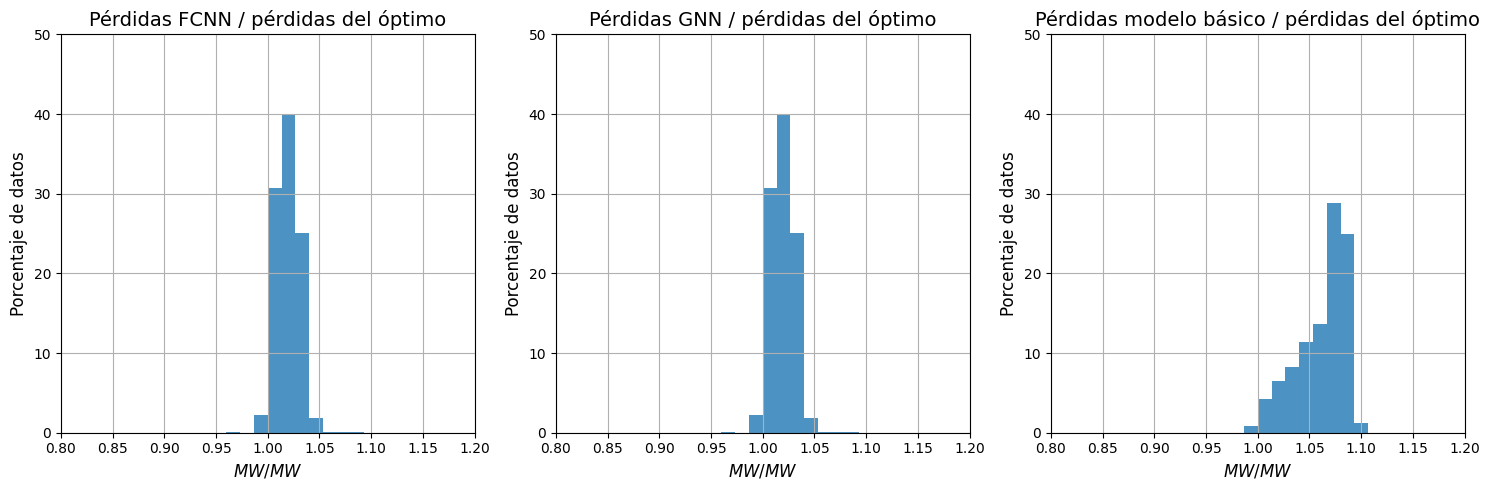

In [30]:
# 3 subplots with histograms
fig, axs = plt.subplots(1,3, figsize=(15,5))
axs[0].hist(v_cost_hist_FCNN[unf_hist_FCNN == 0,0] / v_cost_hist_FCNN[unf_hist_FCNN == 0,1], bins=30, range=(0.8, 1.2),alpha=0.8, weights=np.ones_like(v_cost_hist_FCNN[unf_hist_FCNN == 0,0]) / len(v_cost_hist_FCNN[unf_hist_FCNN == 0,0]) * 100, label='FCNN/opt')
axs[0].set_title("Pérdidas FCNN / pérdidas del óptimo",fontsize=14)
axs[0].grid()
axs[0].set_xlabel(r'$MW/MW$',fontsize=12)
axs[0].set_ylabel("Porcentaje de datos",fontsize=12)
axs[0].set_xlim([0.8, 1.2])
axs[0].set_ylim([0, 50])
axs[1].hist(v_cost_hist_GNN[unf_hist_GNN == 0,0] / v_cost_hist_GNN[unf_hist_GNN == 0,1], bins=30, range=(0.8, 1.2), alpha=0.8, weights=np.ones_like(v_cost_hist_GNN[unf_hist_GNN == 0,0]) / len(v_cost_hist_GNN[unf_hist_GNN == 0,0]) * 100, label='GNN/opt')
axs[1].set_title("Pérdidas GNN / pérdidas del óptimo",fontsize=14)
axs[1].grid()
axs[1].set_xlabel(r'$MW/MW$',fontsize=12)
axs[1].set_ylabel("Porcentaje de datos",fontsize=12)
axs[1].set_xlim([0.8, 1.2])
axs[1].set_ylim([0, 50])
axs[2].hist(v_cost_hist[unf_hist[:,2] == 0,2] / v_cost_hist[unf_hist[:,2] == 0,1], bins=30, range=(0.8, 1.2), alpha=0.8, weights=np.ones_like(v_cost_hist[unf_hist[:,2] == 0,2]) / len(v_cost_hist[unf_hist[:,2] == 0,2]) * 100, label='v1/opt')
axs[2].set_title("Pérdidas modelo básico / pérdidas del óptimo",fontsize=14)
axs[2].grid()
axs[2].set_xlabel(r'$MW/MW$',fontsize=12)
axs[2].set_ylabel("Porcentaje de datos",fontsize=12)
axs[2].set_xlim([0.8, 1.2])
axs[2].set_ylim([0, 50])

plt.tight_layout()
plt.show()



NameError: name 'gap_percentages_hist_FCNN' is not defined

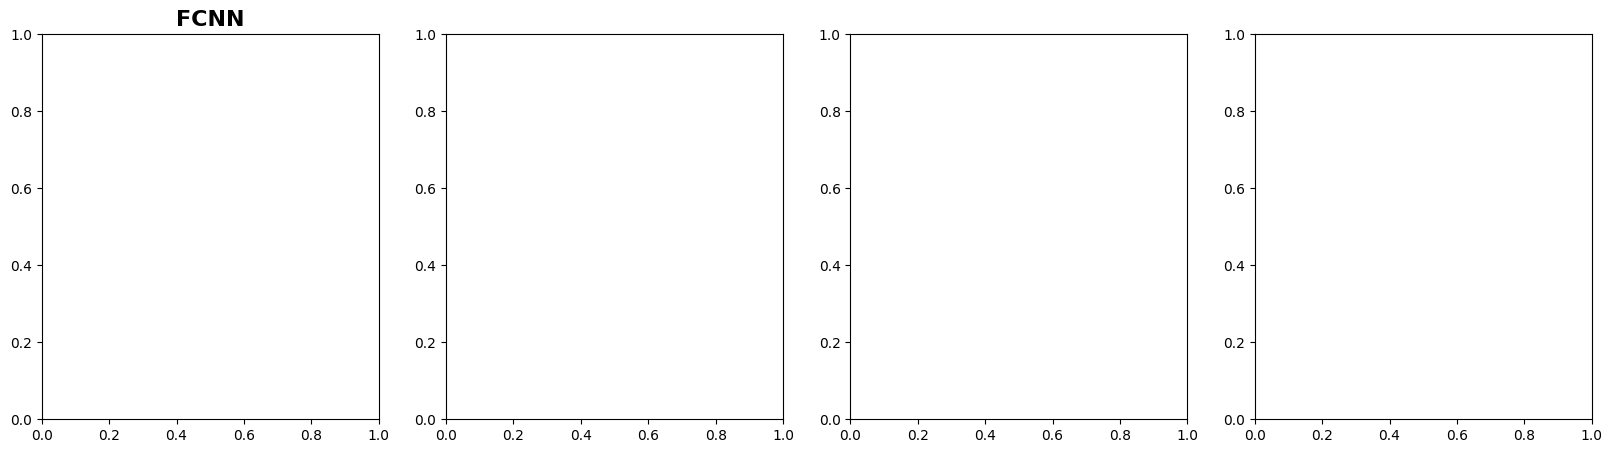

In [31]:
bins = np.linspace(0, 40, 40)  # Creates 10 bins from 0 to 10

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

x_limits = (0, 25)
y_limits = (0, 100)

# Plot the normalized histogram for pred FCNN
axs[0].set_title("FCNN", fontsize=16, fontweight='bold')
axs[0].hist(gap_percentages_hist_FCNN, bins=bins, alpha=0.8, weights=np.ones_like(gap_percentages_hist_FCNN) / len(gap_percentages_hist_FCNN) * 100)  
axs[0].set_xlabel("Porcentaje de violación", fontsize=14)
axs[0].set_ylabel("Porcentaje de ocurrencia", fontsize=14)
axs[0].set_xlim(x_limits)
axs[0].set_ylim(y_limits)
axs[0].grid()

# Plot the normalized histogram for pred GNN
axs[1].set_title("GNN", fontsize=16, fontweight='bold')
axs[1].hist(gap_percentages_hist_GNN, bins=bins, alpha=0.8, weights=np.ones_like(gap_percentages_hist_GNN) / len(gap_percentages_hist_GNN) * 100) 
axs[1].set_xlabel("Porcentaje de violación", fontsize=14)
axs[1].set_ylabel("Porcentaje de ocurrencia", fontsize=14)
axs[1].set_xlim(x_limits)
axs[1].set_ylim(y_limits)
axs[1].grid()

# Plot the normalized histogram for opt
axs[2].set_title("Óptimo", fontsize=16, fontweight='bold')
axs[2].hist(gap_percentages_hist_opt, bins=bins, alpha=0.8, weights=np.ones_like(gap_percentages_hist_opt) / len(gap_percentages_hist_opt) * 100)  
axs[2].set_xlabel("Porcentaje de violación", fontsize=14)
axs[2].set_ylabel("Porcentaje de ocurrencia", fontsize=14)
axs[2].set_xlim(x_limits)
axs[2].set_ylim(y_limits)
axs[2].grid()

# Plot the normalized histogram for v1
axs[3].set_title("Modelo básico", fontsize=16, fontweight='bold')
axs[3].hist(gap_percentages_hist_v1, bins=bins, alpha=0.8, weights=np.ones_like(gap_percentages_hist_v1) / len(gap_percentages_hist_v1) * 100)  
axs[3].set_xlabel("Porcentaje de violación", fontsize=14)
axs[3].set_ylabel("Porcentaje de ocurrencia", fontsize=14)
axs[3].set_xlim(x_limits)
axs[3].set_ylim(y_limits)
axs[3].grid()

plt.tight_layout()
plt.show()
